#### This notebook finds a static factorization of transition dynamics / SCM

In [1]:
import numpy as np
np.random.seed(123)
import torch
from structured_transitions import gen_samples_static, TransitionsData, MaskedNetwork

In [2]:
BATCH_SIZE = 250
MASK_REGULARIZATION_COEFFICIENT = 2e-3
WEIGHT_DECAY = 1e-4
SPLITS = [4, 3, 2] # this is the factorization
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

fns, samples = gen_samples_static(num_seqs=600, seq_len=10, splits=SPLITS) # 6000 datapoints
dataset = TransitionsData(samples)
tr = TransitionsData(dataset[:int(len(dataset)*5/6)])
te = TransitionsData(dataset[int(len(dataset)*5/6):])

train_loader = torch.utils.data.DataLoader(tr, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader  = torch.utils.data.DataLoader(te, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

In [3]:
model = MaskedNetwork(in_features=sum(SPLITS), out_features=sum(SPLITS), 
                      num_hidden_layers=2, num_hidden_units=256).to(dev)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY)
pred_criterion = torch.nn.MSELoss()
mask_criterion = torch.nn.L1Loss()

for epoch in range(100):
  total_pred_loss, total_mask_loss = 0., 0.
  for i, (x, y) in enumerate(train_loader):
    pred_y = model(x.to(dev))
    pred_loss = pred_criterion(y.to(dev), pred_y)
    mask = model.mask
    mask_loss = MASK_REGULARIZATION_COEFFICIENT*mask_criterion(torch.log(1.+mask), torch.zeros_like(mask))

    total_pred_loss += pred_loss
    total_mask_loss += mask_loss
    
    loss = pred_loss + mask_loss
    model.zero_grad()
    loss.backward()
    opt.step()
  if epoch % 10 == 0:
    print('Epoch {} done! Pred loss: {:.5f}, Mask loss: {:.5f}'.format(epoch, total_pred_loss / i, total_mask_loss / i))

Epoch 0 done! Pred loss: 0.00324, Mask loss: 0.00494
Epoch 10 done! Pred loss: 0.00034, Mask loss: 0.00083
Epoch 20 done! Pred loss: 0.00028, Mask loss: 0.00032
Epoch 30 done! Pred loss: 0.00022, Mask loss: 0.00022
Epoch 40 done! Pred loss: 0.00019, Mask loss: 0.00019
Epoch 50 done! Pred loss: 0.00018, Mask loss: 0.00018
Epoch 60 done! Pred loss: 0.00018, Mask loss: 0.00018
Epoch 70 done! Pred loss: 0.00017, Mask loss: 0.00017
Epoch 80 done! Pred loss: 0.00018, Mask loss: 0.00017
Epoch 90 done! Pred loss: 0.00017, Mask loss: 0.00016


In [4]:
m = model.mask.detach().cpu().numpy()
m[m < 0.05] = 0
m.round(2)

array([[0.15, 0.14, 0.16, 0.24, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.23, 0.13, 0.13, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.31, 0.31, 0.14, 0.41, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.13, 0.09, 0.14, 0.21, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.22, 0.13, 0.29, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.25, 0.1 , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.45, 0.25, 0.42, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.23, 0.18],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.21]],
      dtype=float32)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/h/spitis/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/h/spitis/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


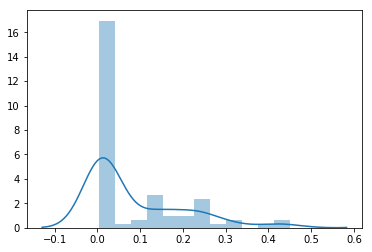

In [6]:
sns.distplot(model.mask.detach().cpu().numpy().reshape(-1), bins=12)